In [350]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [351]:
im = cv2.imread('./images/prtn00.jpg', cv2.IMREAD_COLOR)
im_gray = cv2.imread('./images/prtn00.jpg', cv2.IMREAD_GRAYSCALE)

In [352]:
def get_gauss_pyramid(im, l=4, sub=2, smoothing=1.0):
    res = [im]
    
    for i in range(l):
        tmp = cv2.GaussianBlur(im, (0,0), smoothing)
        tmp = cv2.resize(im, (0,0), fx=1/sub, fy=1/sub)
        res.append(tmp)
        im = tmp
    
    return res

In [353]:
def get_harris_matrix(im, si=1.5, sd=1):
    h, w = im.shape[0], im.shape[1]
    prod = []
    
    dx = cv2.Sobel(im, -1, sd, 0)
    dy = cv2.Sobel(im, -1, 0, sd)
    
    for i in range(h):
        p_tmp = []
        for j in range(w):
            tmp = np.array([[dx[i, j]], [dy[i, j]]])
            tmp_prod = np.matmul(tmp, np.transpose(tmp))
            tmp_prod = cv2.GaussianBlur(tmp_prod, (3,3), si)
            p_tmp.append(tmp_prod)
    
        prod.append(p_tmp)
    
    prod = np.array(prod)
        
    return prod

In [354]:
def get_corner_strength(H):
    res = []
    
    for i in range(H.shape[0]):
        tmp = []
        for j in range(H.shape[1]):
            det = np.linalg.det(H[i, j])
            trace = np.trace(H[i, j])
            if trace == 0:
                tmp.append(0)
            else:
                tmp.append(det/trace)
        res.append(tmp)
        
    return np.array(res)

In [355]:
def get_local_max(im, loc, n=3, threshold=10.0):
    r, c = loc[0], loc[1]
    res = (None, None)
    c_max = -1
    
    for i in range(-1, 1):
        for j in range(-1, 1):
            try:
                if im[r+i][c+j] > c_max:
                    c_max = im[r+i][c+j]
                    res = (r+i, c+j)
            except:
                continue
                
    if c_max > threshold:
        return res
    
    return

In [356]:
def get_maxima(im, threshold=10.0):
    h, w = im.shape[0], im.shape[1]
    res = []
    
    for i in range(h):
        for j in range(w):
            res.append(get_local_max(im, (i, j)))
    
    return res

In [357]:
im_pyramid = get_gauss_pyramid(im_gray)

In [358]:
H = get_harris_matrix(im_pyramid[0])

In [359]:
fhm = get_corner_strength(H)

In [360]:
maxima = get_maxima(fhm)

In [361]:
test_img = im_gray.copy()

In [362]:
for p in maxima:
    test_img = cv2.circle(im_gray, p, 2, (0, 0, 255), 2)

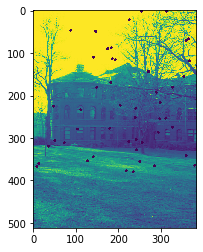

In [363]:
plt.imshow(test_img)

In [364]:
cv2.imwrite("test.png", test_img)

True